# Implémentation du Mean Shift

## 0. Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndimage
plt.rcParams['image.cmap'] = 'gray' 
from skimage.color import rgb2luv,luv2rgb
import random as rd
from drawnow import drawnow

## 1. Mean shift

Dans cette partie, on implante une version simple du mean-shift, appliquée à des points 2d tirés selon une distribution gaussienne.

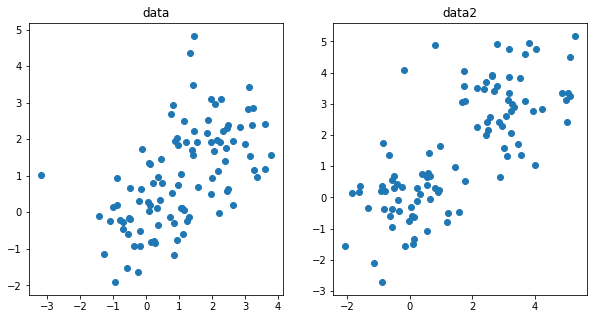

In [2]:
def compute_vector(mean1, var1, mean2, var2, nb_points):
    """
    Fonction qui produit les données de test
    """
    N = nb_points//2
    
    data1 = np.random.multivariate_normal(2*[mean1], np.diag(2*[var1]), N)
    data2 = np.random.multivariate_normal(2*[mean2], np.diag(2*[var2]), N)
    
    return np.concatenate((data1, data2))


data = compute_vector(0, 1, 2, 1, 100)
data2 = compute_vector(0, 1, 3, 1, 100) # plus facile à clusteriser car les 2 nuages de points sont plus espacés

fig = plt.figure(figsize = (10,5))
    
ax = fig.add_subplot(1, 2, 1)
ax.set_title("data")
ax.scatter(*data.T)
    
ax = fig.add_subplot(1, 2, 2)
ax.set_title("data2")
ax.scatter(*data2.T)

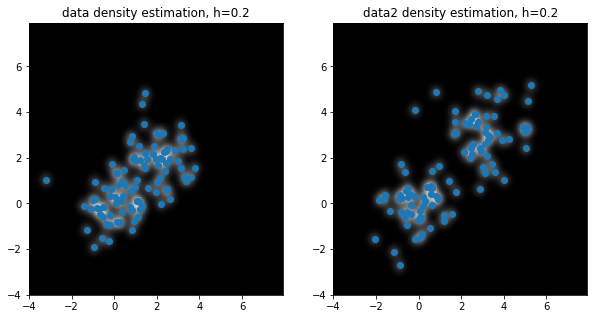

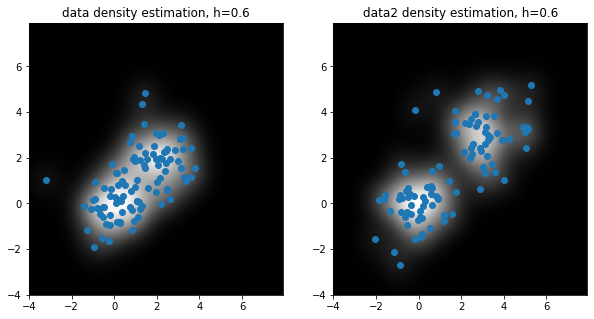

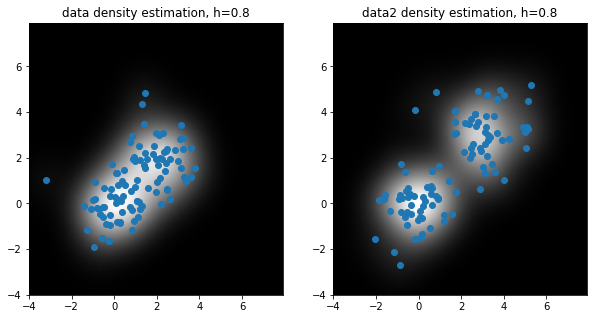

In [3]:
def norm2(x):
    """
    Norme euclidienne au carré
    """
    return np.sum(x**2)

def k_n(r):
    """
    noayux normal
    """
    return np.exp(-0.5*r)

def k_e(r):
    """
    Noyau d'Epanechnikov
    """
    return 1-r if 0<=r<=1 else 0

def k_u(r):
    """
    Noyau uniforme
    """
    return 1 if 0<=r<=1 else 0


def kernel_density_estimator(x, y, data, h, k=k_n):
    """
    Estimateur de la densité
    """
    n = len(data)
    sum = 0
    for i in range(n):
        sum += k( ((x-data[i][0])**2 + (y-data[i][1])**2)/(h**2) )
    return sum/(len(data) * h)

x = np.arange(-4,8,0.1)    
X,Y = np.meshgrid(x,x)

Test = [0.2, 0.6, 0.8]
for t in Test:
    
    fig = plt.figure(figsize = (10,5))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("data density estimation, h="+str(t))
    ax.pcolormesh(X, Y, kernel_density_estimator(X,Y, data, t, k_n), shading="gouraud")
    ax.scatter(*data.T)

    
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title("data2 density estimation, h="+str(t))
    ax.pcolormesh(X, Y, kernel_density_estimator(X,Y, data2, t), shading="gouraud")
    ax.scatter(*data2.T)

plt.show()

Le meanshift repose sur le calcul du vercteur mean qui sert dans les itérations:

$$
m_{h,k}(x) = \frac{\sum_{i=1}^{n} x_i k(|| \frac{x-x_i}{h} ||^2)} {\sum_{i=1}^{n} k(|| \frac{x-x_i}{h} ||^2)}
$$

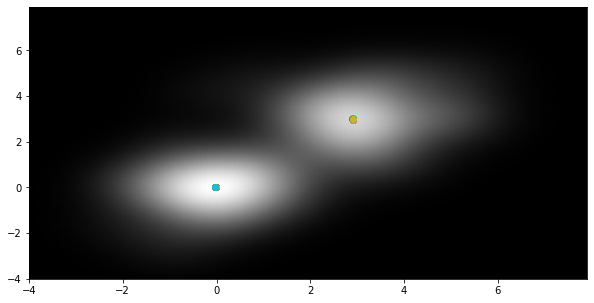

In [4]:
def m(elem, data, h, dist=norm2, kernel=k_n):
    """
    Calcul du mean
    """
    n = len(data)
    sum1 = 0
    sum2 = 0
    for i in range(n):
        ker = -kernel( dist((elem-data[i])/h) )
        sum1 += data[i]* ker
        sum2 += ker
        
    return sum1/(sum2 + 1e-16)


def mean_shift_algo(elem, data, h, n_iter, kernel=k_n, dist=norm2 ):
    """
    Itérations meanshift
    """
    
    elem2 = m(elem, data, h, dist, k_n)
    for _ in range(n_iter):
        elem = elem2
        elem2 = m(elem, data, h, dist, k_n)
        
    return elem2



H = 0.8

x = np.arange(-4,8,0.1)    
X,Y = np.meshgrid(x,x)
plt.figure(figsize=(10,5))
plt.pcolormesh(X, Y, kernel_density_estimator(X, Y, data2, H, k_n ), shading="gouraud")

for i in range(99):
    converge = mean_shift_algo(data2[i], data2, H, 10, kernel=k_n)
    plt.scatter(*converge)

plt.show()

# 2. Segmentation

Pour la segmentation, on va dans un premier temps appliquer les itérations du *meanshit* sur l'image, que l'on aura au préalable passée dans un domaine en cinq dimensions: deux d'espaces (coordonnées des pixels) et trois de couleurs (coordonnées Luv) $(i,j,L,u,v)$. Ces itérations seront faites avec le noyau multivarié:
$$
k_{k,h_s,h_r}(x) = k(||\frac{x^s}{h_s}||^2)k(||\frac{x^r}{h_r}||^2)
$$

In [5]:
#Outils pour les images

def Img_to_data(Img):
    """
    Luv -> 5d
    """
    out = np.zeros((Img.shape[0], Img.shape[1], 5))
    for i in range(Img.shape[0]):
        for j in range(Img.shape[1]):
            out[i,j] =np.array([i,j,*Img[i][j]])
    return out


def data_to_Img(z):
    """
    5d -> Luv
    """
    w,h,_ = z.shape
    I_out = np.zeros((int(w),int(h),3))
    for i in range(w):
        for j in range(h):
            I_out[i,j] = z[i,j][2:]
    return I_out

In [10]:
def msr(elem, data, hs, hr, dist=norm2, k=k_n):
    """
    vecteur mean pour les images
    """
    width,height,size = data.shape
    sum1 = np.zeros(size)
    sum2 = 0
    
    i_min= np.max((0, elem[0] - hs))
    i_max = np.min((width, elem[0] + hs + 1))
    
    j_min = np.max((0, elem[1] - hs))
    j_max = np.min((height, elem[1] + hs + 1))
    
    for i in range(int(i_min), int(i_max)):     
        for j in range(int(j_min), int(j_max)):
            x = elem-data[i,j]
            # noyau ksr
            ker = -k(dist(x[0:2]/hs))*k(dist(x[2:]/hr))
            sum1 += data[i,j]* ker
            sum2 += ker
        
    return sum1/(sum2 + 1e-16)

def ms_filtering(Img, hs, hr, n_iter, dist=norm2, k=k_n):
    """
    Itérations meanshift pour les images (sous format 5d)
    """
    data = Img_to_data(Img)
    z = np.zeros(data.shape)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            print('step: '+str(i+1)+'/'+str(len(data))+'\r', sep=' ', end='', flush=True)
            elem = data[i,j]
            for l in range(n_iter):
                elem2 = msr(elem, data, hs, hr, dist, k)
                elem = elem2
            
            z[i,j] = np.concatenate(([i,j], elem[2:]))
        
    return z

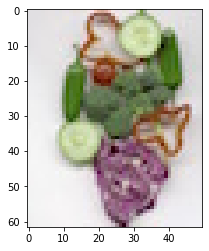

In [11]:
name='legumes_small.jpg'

I = plt.imread(name)
I_luv = rgb2luv(I)
plt.imshow(I)

In [71]:
#itérations meanshift
z = ms_filtering(I_luv, 5, 20, 10,norm2,k_u)

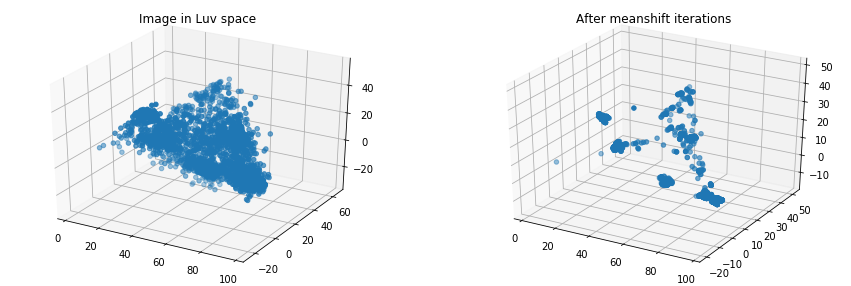

In [72]:
I_new = data_to_Img(z)


fig = plt.figure(figsize = (15,5))
    
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("Image in Luv space")
ax.scatter(*I_luv.T)

    
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("After meanshift iterations")
#ax.scatter(*I_luv.T)
ax.scatter(*I_new.T)

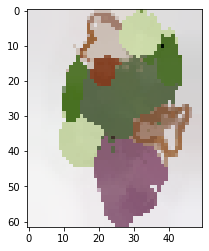

In [73]:
plt.figure()
plt.imshow(luv2rgb(I_new))

In [101]:
def clustering(z,range_s,range_r,dist=norm2):
    """
    Pour déterminer les clusters sur l'image filtrée
    """
    w,h,_=z.shape
    Clusters = [z[0,0]]
    labels = np.zeros((w,h))
    for i in range(w):
        for j in range(h):
            labelized = False
            for l,c in enumerate(Clusters):
                if dist(z[i,j][:2]-c[:2])<range_s and dist(z[i,j][2:]-c[2:])<range_r:
                    labels[i,j] = l
                    labelized = True
            if labelized == False:
                labels[i,j] = len(Clusters)
                Clusters.append(z[i,j])  
                    
    return labels,Clusters


def ms_segmentation(z,hs,hr,dist=norm2):
    """
    Pour réaliser la segmentation
    """
    labels,Clusters = clustering(z,50*hs,20*hr,dist)
    w,h,_=z.shape
    print(f"{len(Clusters)} clusters found")
    
    I_out = np.zeros((int(w),int(h),3))
    for i in range(w):
        for j in range(h):
            I_out[i,j] = Clusters[int(labels[i,j])][2:]
    
    #pour marquer les clusters
    for c in Clusters:
        I_out[int(c[0]),int(c[1])] = [0.05, 0.2, 0.04]
    return I_out

In [102]:
I_segmented = ms_segmentation(z, 4, 30, norm2)

41 clusters found


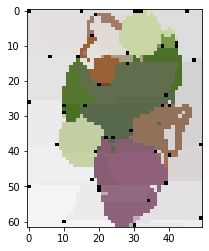

In [103]:
plt.figure()
plt.imshow(luv2rgb(I_segmented))